# Setup

In [20]:
!conda init

no change     /home/ianjoffe/miniconda3/condabin/conda
no change     /home/ianjoffe/miniconda3/bin/conda
no change     /home/ianjoffe/miniconda3/bin/conda-env
no change     /home/ianjoffe/miniconda3/bin/activate
no change     /home/ianjoffe/miniconda3/bin/deactivate
no change     /home/ianjoffe/miniconda3/etc/profile.d/conda.sh
no change     /home/ianjoffe/miniconda3/etc/fish/conf.d/conda.fish
no change     /home/ianjoffe/miniconda3/shell/condabin/Conda.psm1
no change     /home/ianjoffe/miniconda3/shell/condabin/conda-hook.ps1
no change     /home/ianjoffe/miniconda3/lib/python3.12/site-packages/xontrib/conda.xsh
no change     /home/ianjoffe/miniconda3/etc/profile.d/conda.csh
no change     /home/ianjoffe/.bashrc
No action taken.


In [ ]:
!exec $SHELL

(base) ]0;ianjoffe@g004: ~/RepresentationDebiasingianjoffe@g004:~/RepresentationDebiasing$ 

In [2]:
!pip install -r "requirements.txt"

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [1]:
import json
import os
from pathlib import Path
import pickle

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import penzai
from penzai import pz
from penzai.toolshed import save_intermediates
from penzai.models.transformer import variants

import kagglehub
import orbax.checkpoint
from jax.experimental import mesh_utils
import sentencepiece as spm

In [2]:
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()
pz.ts.active_autovisualizer.set_interactive(pz.ts.ArrayAutovisualizer())
pz.ts.register_context_manager_magic()

### Set up the model, including download if necessary

In [3]:
kaggle_credentials = json.load(open('kaggle.json'))
kagglehub.config.set_kaggle_credentials(kaggle_credentials["username"], kaggle_credentials["key"])
kagglehub.login()

weights_dir = kagglehub.model_download('google/gemma/flax/2b')
# weights_dir = kagglehub.model_download('google/gemma-2/flax/gemma2-2b')

ckpt_path = os.path.join(weights_dir, '2b')
# ckpt_path = os.path.join(weights_dir, 'gemma2-2b')
vocab_path = os.path.join(weights_dir, 'tokenizer.model')

vocab = spm.SentencePieceProcessor()
vocab.Load(vocab_path)

checkpointer = orbax.checkpoint.PyTreeCheckpointer()
metadata = checkpointer.metadata(ckpt_path)

n_devices = jax.local_device_count()
sharding_devices = mesh_utils.create_device_mesh((n_devices,))
sharding = jax.sharding.PositionalSharding(sharding_devices)
restore_args = jax.tree_util.tree_map(
    lambda m: orbax.checkpoint.ArrayRestoreArgs(
        restore_type=jax.Array,
        sharding=sharding.reshape((1,) * (len(m.shape) - 1) + (n_devices,))
    ),
    metadata,
)
flat_params = checkpointer.restore(ckpt_path, restore_args=restore_args)

Kaggle credentials set.


VBox(children=(HTML(value='<center> <img\nsrc=https://www.kaggle.com/static/images/site-logo.png\nalt=\'Kaggle…

In [99]:
model = variants.gemma.gemma_from_pretrained_checkpoint(flat_params, upcast_activations_to_float32=True)

model_saving_intermediates = (
    pz.select(model)
    .at_instances_of(penzai.models.transformer.model_parts.TransformerBlock)
    .apply_and_inline(
        lambda l: [l, save_intermediates.SaveIntermediate(pz.StateVariable(None))]
    )
)


# Useful Functions and Definitions

In [161]:
def tokenize_and_pad_vectorized(prompts, pad_value=vocab.pad_id(), padding_last=False):
    tokenized_prompts = prompts.apply(lambda prompt: [vocab.bos_id()] + vocab.EncodeAsIds(prompt))
    max_length = tokenized_prompts.apply(len).max()
    if padding_last:
        padded_prompts = tokenized_prompts.apply(lambda tokens: tokens + [pad_value] * (max_length - len(tokens)))
        attention_masks = tokenized_prompts.apply(lambda tokens: [1] * len(tokens) + [0] * (max_length - len(tokens)))
    else:
        padded_prompts = tokenized_prompts.apply(lambda tokens: [pad_value] * (max_length - len(tokens)) + tokens)
        attention_masks = tokenized_prompts.apply(lambda tokens: [0] * (max_length - len(tokens)) + [1] * len(tokens))
    return jnp.array(np.stack(padded_prompts.values)), jnp.array(np.stack(attention_masks.values))

In [4]:
# for gemma-1-2b these are by orders of magnitude the most common reasonable tokens to express opinions on bills
neg_tokens = [" no", "no", " NO", "NO", " No", "No", " against", "against", " Against", "Against", " AGAINST"] # AGAINST without a space was two tokens
pos_tokens = [" yes", "yes", " YES", "YES", " Yes", "Yes", " for", "for", " For", "For", " FOR"]
pos_tokenids = vocab.EncodeAsIds(pos_tokens)
neg_tokenids = vocab.EncodeAsIds(neg_tokens)

In [5]:
DPrompt1 = lambda x: "I am an American congressperson in the Democratic Party. I was asked to vote on the following bill: \n" + x + "\n I voted"
RPrompt1 = lambda x: "I am an American congressperson in the Republican Party. I was asked to vote on the following bill: \n" + x + "\n I voted"
DPrompt2 = lambda x: "I am a left-leaning American congressperson. I was asked to vote on the following bill: \n" + x + "\n I voted"
RPrompt2 = lambda x: "I am a right-leaning American congressperson. I was asked to vote on the following bill: \n" + x + "\n I voted"
DPrompt3 = lambda x: "I am a Liberal American congressperson. I was asked to vote on the following bill: \n" + x + "\n I voted"
RPrompt3 = lambda x: "I am a Conservative American congressperson. I was asked to vote on the following bill: \n" + x + "\n I voted"
DPrompt4 = lambda x: "I am an American congressperson who supports Joe Biden. I was asked to vote on the following bill: \n" + x + "\n I voted"
RPrompt4 = lambda x: "I am an American congressperson who supports Donald Trump. I was asked to vote on the following bill: \n" + x + "\n I voted"
all_prompts = [DPrompt1, DPrompt2, DPrompt3, DPrompt4, RPrompt1, RPrompt2, RPrompt3, RPrompt4]

# Run Model

### Process Data for Model Input

In [6]:
summaries_df = pd.read_csv("bill_summaries_and_sponsors.csv")
summaries_df["true_party"] = np.select([summaries_df["D Sponsors"] >= 4*summaries_df["R Sponsors"],
                        summaries_df["D Sponsors"]*4 <= summaries_df["R Sponsors"]],
                       [-1, 1], default=0)
summaries_df_sample = summaries_df.sample(n=10000, replace=False, weights=(summaries_df["true_party"]!=0), random_state=137).reset_index(drop=True)

In [7]:
summaries_df_sample

,Unnamed: 0,congress_num,bill_type,bill_num,summary,D Sponsors,R Sponsors,true_party
0,136810,108,S,3016,<p>Asia Freedom Act of 2004 - Authorizes the ...,0,2,1
1,11163,117,HR,3107,<p><strong>Helping to Encourage Real Opportun...,7,0,-1
2,93356,111,HR,4932,<p>Small Business Development Centers Relief ...,1,0,-1
3,94149,111,HR,171,<p>Sangre de Cristo National Heritage Area Ac...,2,0,-1
4,68467,113,HR,829,<p>Amends the Wild and Scenic Rivers Act to d...,2,0,-1
...,...,...,...,...,...,...,...,...
9995,103904,110,HR,854,<p>City Youth Violence Recovery Act - Authori...,57,0,-1
9996,88731,112,S,3665,<p>Foster Youth Higher Education Opportunitie...,9,2,-1
9997,76339,113,S,2089,<p>Supplemental Security Income Restoration A...,3,0,-1
9998,13870,117,HR,5786,<p><strong>Defund the People's Liberation Arm...,0,5,1


### Run the Model - Only output last token

I tried to figure out how to get the model to only output code for the last token instead of all of them. Turns out it's not that much faster (I think due to caching) and a lot more under-the-surface so I don't think I'll use it.

In [ ]:
batch_len = 1
current_summaries = summaries.iloc[:batch_len]
prompts = pd.concat([current_summaries.apply(p) for p in all_prompts]).reset_index(drop=True)
tokenized_prompts, attention_masks = tokenize_and_pad_vectorized(prompts, padding_last=True)
input_batch = pz.nx.wrap(tokenized_prompts).tag("batch", "seq")

input_batch_attn_masks = pz.nx.wrap(make_causal_attn_mask(attention_masks)).tag("batch", "seq", "kv_seq")
input_batch_positions = pz.nx.wrap(build_positions_from_mask(attention_masks)).tag("batch", "seq")
model_inputs = gemma.model_core.GemmaInputs(tokens=input_batch, positions=input_batch_positions, attention_mask=input_batch_attn_masks)

In [11]:
inference_gemma, initial_inference_state = gemma.sampling_mode.GemmaKVCachingTransformer.from_uncached(
    model,
    cache_len=600,
    batch_axes={"batch": batch_len*8},
)

In [13]:
gemma.simple_decoding_loop.prefill(model=inference_gemma,
                                   initial_cache_state=initial_inference_state,
                                   prompt=model_inputs.tokens,
                                   pad_id=0)

(<NamedArray float32(| batch:8, vocabulary:256128) ≈-2.3e+01 ±4.4 [≥-6.3e+01, ≤-1.4] nonzero:2_049_024 (wrapping jax.Array)
   <Arrayviz rendering>
   Replicated across 1 GPU devices (click to expand)
 >,
 SamplingState(
   kv_cache_state=GemmaKVCachingState(
     cache_len=600,
     batch_axes={'batch': 8},
     kv_caches={'WithSideInputsFromInputTuple.body/WithSideInputsFromInputTuple.body/WithConstantSideInputs.body/Sequential.sublayers[3]/GemmaTransformerBlock.sublayers[0]/Residual.delta/Sequential.sublayers[1]/GemmaKVCachingAttention.kv_cache': (<NamedArray float32(| batch:8, projection:256, seq:600) ≈0.0029 ±0.78 [≥-1.2e+01, ≤7.0] zero:761_856 nonzero:466_944 (wrapping jax.Array)>, <NamedArray float32(| batch:8, projection:256, seq:600) ≈-0.018 ±1.2 [≥-2e+01, ≤1.4e+01] zero:761_856 nonzero:466_944 (wrapping jax.Array)>), 'WithSideInputsFromInputTuple.body/WithSideInputsFromInputTuple.body/WithConstantSideInputs.body/Sequential.sublayers[4]/GemmaTransformerBlock.sublayers[0]/Residual.delta/Sequential.sublayers[1]/GemmaKVCachingAttention.kv_cache': (<NamedArray float32(| batch:8, projection:256, seq:600) ≈0.005 ±0.82 [≥-6.8, ≤1.9e+01] zero:761_856 nonzero:466_944 (wrapping jax.Array)>, <NamedArray float32(| batch:8, projection:256, seq:600) ≈0.0075 ±0.7 [≥-7.1, ≤8.3] zero:761_856 nonzero:466_944 (wrapping jax.Array)>), 'WithSideInputsFromInputTuple.body/WithSideInputsFromInputTuple.body/WithConstantSideInputs.body/Sequential.sublayers[5]/GemmaTransformerBlock.sublayers[0]/Residual.delta/Sequential.sublayers[1]/GemmaKVCachingAttention.kv_cache': (<NamedArray float32(| batch:8, projection:256, seq:600) ≈-0.02 ±0.89 [≥-1.4e+01, ≤1.2e+01] zero:761_856 nonzero:466_944 (wrapping jax.Array)>, <NamedArray float32(| batch:8, projection:256, seq:600) ≈0.00031 ±0.55 [≥-7.6, ≤8.8] zero:761_856 nonzero:466_944 (wrapping jax.Array)>), 'WithSideInputsFromInputTuple.body/WithSideInputsFromInputTuple.body/WithConstantSideInputs.body/Sequential.sublayers[6]/GemmaTransformerBlock.sublayers[0]/Residual.delta/Sequential.sublayers[1]/GemmaKVCachingAttention.kv_cache': (<NamedArray float32(| batch:8, projection:256, seq:600) ≈0.018 ±0.88 [≥-6.9, ≤1.3e+01] zero:761_856 nonzero:466_944 (wrapping jax.Array)>, <NamedArray float32(| batch:8, projection:256, seq:600) ≈0.0025 ±0.52 [≥-5.4, ≤7.6] zero:761_856 nonzero:466_944 (wrapping jax.Array)>), 'WithSideInputsFromInputTuple.body/WithSideInputsFromInputTuple.body/WithConstantSideInputs.body/Sequential.sublayers[7]/GemmaTransformerBlock.sublayers[0]/Residual.delta/Sequential.sublayers[1]/GemmaKVCachingAttention.kv_cache': (<NamedArray float32(| batch:8, projection:256, seq:600) ≈0.026 ±0.94 [≥-7.3, ≤1.4e+01] zero:761_856 nonzero:466_944 (wrapping jax.Array)>, <NamedArray float32(| batch:8, projection:256, seq:600) ≈-0.0039 ±0.46 [≥-4.9, ≤5.5] zero:761_856 nonzero:466_944 (wrapping jax.Array)>), 'WithSideInputsFromInputTuple.body/WithSideInputsFromInputTuple.body/WithConstantSideInputs.body/Sequential.sublayers[8]/GemmaTransformerBlock.sublayers[0]/Residual.delta/Sequential.sublayers[1]/GemmaKVCachingAttention.kv_cache': (<NamedArray float32(| batch:8, projection:256, seq:600) ≈0.036 ±0.95 [≥-8.7, ≤1.4e+01] zero:761_856 nonzero:466_944 (wrapping jax.Array)>, <NamedArray float32(| batch:8, projection:256, seq:600) ≈-0.0025 ±0.43 [≥-5.8, ≤6.5] zero:761_856 nonzero:466_944 (wrapping jax.Array)>), 'WithSideInputsFromInputTuple.body/WithSideInputsFromInputTuple.body/WithConstantSideInputs.body/Sequential.sublayers[9]/GemmaTransformerBlock.sublayers[0]/Residual.delta/Sequential.sublayers[1]/GemmaKVCachingAttention.kv_cache': (<NamedArray float32(| batch:8, projection:256, seq:600) ≈0.00071 ±0.82 [≥-1.5e+01, ≤8.3] zero:761_856 nonzero:466_944 (wrapping jax.Array)>, <NamedArray float32(| batch:8, projection:256, seq:600) ≈-0.013 ±0.51 [≥-6.1, ≤5.1] zero:761_856 nonzero:466_944 (wrapping jax.Array)>), 'WithSideInputsFromInputTuple.body/WithSideInputsFromInputTuple.body/WithConstantSideInputs.body/Sequential.sub

### Run the Model

In [8]:
D1out, D2out, D3out, D4out, R1out, R2out, R3out, R4out = [], [], [], [], [], [], [], []
D1stream, D2stream, D3stream, D4stream, R1stream, R2stream, R3stream, R4stream = [], [], [], [], [], [], [], []
outputs = [D1out, D2out, D3out, D4out, R1out, R2out, R3out, R4out]
streams  = [D1stream, D2stream, D3stream, D4stream, R1stream, R2stream, R3stream, R4stream]
pickle_files = {"D1out":"model_outputs/D1out.pkl", "D2out":"model_outputs/D2out.pkl", "D3out":"model_outputs/D3out.pkl", "D4out":"model_outputs/D4out.pkl", "R1out":"model_outputs/R1out.pkl", "R2out":"model_outputs/R2out.pkl", "R3out":"model_outputs/R3out.pkl", "R4out":"model_outputs/R4out.pkl",
                "D1stream":"model_outputs/D1stream.pkl", "D2stream":"model_outputs/D2stream.pkl", "D3stream":"model_outputs/D3stream.pkl", "D4stream":"model_outputs/D4stream.pkl", "R1stream":"model_outputs/R1stream.pkl", "R2stream":"model_outputs/R2stream.pkl", "R3stream":"model_outputs/R3stream.pkl", "R4stream":"model_outputs/R4stream.pkl"}

Run inference through the subsample of prompts, with flexible batch size and intermittent. Save outputs and activations as described above

In [ ]:
inference_batch_size = 1
save_frequency = 20
num_prompts = len(all_prompts)
initial_position = 420
ending_position = 1000

for i in range(initial_position, ending_position, inference_batch_size):

    # prepare model input for batch
    selected_rows = summaries_df_sample.iloc[i:min(i+inference_batch_size, len(summaries_df_sample))]
    prompts = pd.concat([selected_rows["summary"].apply(p) for p in all_prompts]).reset_index(drop=True)
    tokenized_prompts, attention_masks = tokenize_and_pad_vectorized(prompts, padding_last=False)    # TODO: need to further investigate the padding
    input_batch = pz.nx.wrap(tokenized_prompts).tag("prompt", "seq")
    input_token_pos = (pz.nx.arange("seq", input_batch.named_shape["seq"]) *
                       pz.nx.ones({"prompt":input_batch.named_shape["prompt"]}) + 1) * (input_batch != 0) - 1

    # run model and extract activations
    model_outputs = model_saving_intermediates(input_batch, token_positions=input_token_pos).untag("seq")[-1]

    intermediates = pz.nx.stack([
        saver.saved.value for saver in (
            pz.select(model_saving_intermediates)
            .at_instances_of(save_intermediates.SaveIntermediate)
            .get_sequence()
        )
    ], axis_name="layer").untag("seq")[-1]

    # save output and activation to runtime's data structure
    for p in range(num_prompts):
        outputs[p].append(model_outputs.untag("prompt")[p*inference_batch_size:(p+1)*inference_batch_size].tag("bill"))
        streams[p].append(intermediates.untag("prompt")[p*inference_batch_size:(p+1)*inference_batch_size].tag("bill"))

    print("Completed Inference on " + str(i) + " bill")
    
    if ((i+1) % save_frequency == 0) or (i == ending_position-1):
        # save activtions and outputs persistently
        
        for p in range(num_prompts):
            outputs[p][0] = pz.nx.concatenate(outputs[p], "bill")
            streams[p][0] = pz.nx.concatenate(streams[p], "bill")

        for lst in pickle_files.keys():
            if Path(pickle_files[lst]).is_file():
                with open(pickle_files[lst], "rb") as f:
                    previous_entries = pickle.load(f)
                updated_entries = pz.nx.concatenate([previous_entries, eval(lst)[0]], "bill")
                with open(pickle_files[lst], "wb") as f:
                    pickle.dump(updated_entries, f) 
            else:
                with open(pickle_files[lst], "wb") as f:
                    pickle.dump(eval(lst)[0], f) 

        # reset runtime data after saving persistently
        D1out, D2out, D3out, D4out, R1out, R2out, R3out, R4out = [], [], [], [], [], [], [], []
        D1stream, D2stream, D3stream, D4stream, R1stream, R2stream, R3stream, R4stream = [], [], [], [], [], [], [], []
        outputs = [D1out, D2out, D3out, D4out, R1out, R2out, R3out, R4out]
        streams  = [D1stream, D2stream, D3stream, D4stream, R1stream, R2stream, R3stream, R4stream]
        
        print("Saved up to bill " + str(i))
        

# Evaluate Output

In [9]:
with open(pickle_files["D1out"], "rb") as f:
    D1out = pickle.load(f)
with open(pickle_files["D1stream"], "rb") as f:
    D1stream = pickle.load(f)
with open(pickle_files["D2out"], "rb") as f:
    D2out = pickle.load(f)
with open(pickle_files["D2stream"], "rb") as f:
    D2stream = pickle.load(f)
with open(pickle_files["D3out"], "rb") as f:
    D3out = pickle.load(f)
with open(pickle_files["D3stream"], "rb") as f:
    D3stream = pickle.load(f)
with open(pickle_files["D4out"], "rb") as f:
    D4out = pickle.load(f)
with open(pickle_files["D4stream"], "rb") as f:
    D4stream = pickle.load(f)
with open(pickle_files["R1out"], "rb") as f:
    R1out = pickle.load(f)
with open(pickle_files["R1stream"], "rb") as f:
    R1stream = pickle.load(f)
with open(pickle_files["R2out"], "rb") as f:
    R2out = pickle.load(f)
with open(pickle_files["R2stream"], "rb") as f:
    R2stream = pickle.load(f)
with open(pickle_files["R3out"], "rb") as f:
    R3out = pickle.load(f)
with open(pickle_files["R3stream"], "rb") as f:
    R3stream = pickle.load(f)
with open(pickle_files["R4out"], "rb") as f:
    R4out = pickle.load(f)
with open(pickle_files["R4stream"], "rb") as f:
    R4stream = pickle.load(f)

In [10]:
# Let DEM and REP be whether the llm is prompted to be a democrat or republican
# Let YES be how supportive the llm is of a bill, and let NO be how oppossed it is

# YES(bill) - NO(bill)
def llm_sentiment_difference(outputs):
    pos_sums = pz.nx.nmap(jax.scipy.special.logsumexp)(outputs.untag("vocabulary")[pos_tokenids])
    neg_sums = pz.nx.nmap(jax.scipy.special.logsumexp)(outputs.untag("vocabulary")[neg_tokenids])
    return pos_sums - neg_sums

# rate on 0 to 1 scale (YES(bill) - NO(bill))
def llm_sentiment_scores(outputs):
    assert outputs.named_shape["bill"] > 1, "llm_sentiment_scores is meant to score many bills relative to each other"
    sentiment_difference = llm_sentiment_difference(outputs)
    ranks = pz.nx.nmap(jnp.argsort)(pz.nx.nmap(jnp.argsort)(sentiment_difference.untag("bill"))).tag("bill")
    scores = ranks / len(ranks)
    return scores

# (YES(bill | REP) - NO(bill |REP)) - (YES(bill | DEM) - NO(bill | DEM))
def llm_partisan_scores_1(dem_outputs, rep_outputs):
    # this method first ranks how left or right a bill is, and then compares the rank difference
    rep_sentiment_scores = llm_sentiment_scores(rep_outputs)
    dem_sentiment_scores = llm_sentiment_scores(dem_outputs)
    return rep_sentiment_scores - dem_sentiment_scores

def llm_partisan_scores_2(dem_outputs, rep_outputs):
    # this method first takes the difference in how left or right a bill is, and then ranks the differences
    # otherwise same as llm_partisan_scores_1
    rep_sentiment_diff = llm_sentiment_difference(rep_outputs)
    dem_sentiment_diff = llm_sentiment_difference(dem_outputs)
    net_sentiment_diff = rep_sentiment_diff - dem_sentiment_diff
    ranks = pz.nx.nmap(jnp.argsort)(pz.nx.nmap(jnp.argsort)(net_sentiment_diff.untag("bill"))).tag("bill")
    scores = ranks / len(ranks)
    return scores

# ranks bills by their partisan score, and says the bottom THRESHOLD are left and the top THRESHOLD are right. 
# then calculates the percent of such ratings that agree with the actual support of the bill, as determined by its sponsors
def llm_partisan_scores_accuracy(partisan_scores, true_parties, threshold=0.5, scoring_function=llm_partisan_scores_1):
    partisan_ranks = jax.device_get(partisan_scores.untag("bill").unwrap()).argsort()
    llm_assigned_dem = partisan_ranks[:int(len(partisan_ranks) * threshold)]
    llm_assigned_dem_bool = np.array([True if i in llm_assigned_dem else False for i in range(len(partisan_ranks))])
    # display(summaries_df_sample.iloc[partisan_ranks].assign(llm_dem=llm_assigned_dem_bool))
    llm_assigned_rep = partisan_ranks[int(len(partisan_ranks) * (1-threshold)):]
    llm_assigned_rep_bool = np.array([True if i in llm_assigned_rep else False for i in range(len(partisan_ranks))])
    llm_assignments = llm_assigned_rep_bool.astype(int) - llm_assigned_dem_bool.astype(int)
    accuracy = sum(llm_assignments == true_parties) / sum(llm_assignments != 0)
    return accuracy

The point of looking at the llm's "accuracy" is to see how well the llm understands politics, since if it doesn't even understand what kinds of bills would be supported by republicans or democrats, the project has no hope. I'd also like to select a threshold that gives good enough accuracy while also providing enough samples. Whether these numbers are "good enough" is up to interpretation. I can also use this data to choose which scoring function to use, and pick other similar "hyperparameters". 

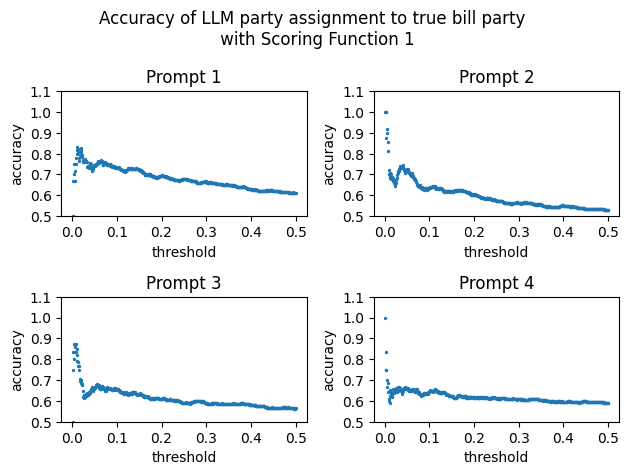

In [172]:
thresholds = np.arange(0.001, 0.501, 0.001)
true_parties = summaries_df_sample[:1000]["true_party"]

fig, ax = plt.subplots(2,2)
ax[0][0].scatter(thresholds, [llm_partisan_scores_accuracy(llm_partisan_scores(D1out, R1out), true_parties, threshold=i) for i in thresholds], s=2)
ax[0][0].set_title("Prompt 1")
ax[0][1].scatter(thresholds, [llm_partisan_scores_accuracy(llm_partisan_scores(D2out, R2out), true_parties, threshold=i) for i in thresholds], s=2)
ax[0][1].set_title("Prompt 2")
ax[1][0].scatter(thresholds, [llm_partisan_scores_accuracy(llm_partisan_scores(D3out, R3out), true_parties, threshold=i) for i in thresholds], s=2)
ax[1][0].set_title("Prompt 3")
ax[1][1].scatter(thresholds, [llm_partisan_scores_accuracy(llm_partisan_scores(D4out, R4out), true_parties, threshold=i) for i in thresholds], s=2)
ax[1][1].set_title("Prompt 4")

for axs in ax.flat:
    axs.set_xlabel("threshold")
    axs.set_ylabel("accuracy")
    axs.set_ylim(0.5, 1)
    axs.set_xticks(np.arange(0, 0.51, 0.1))
    axs.set_yticks(np.arange(0.5, 1.1, 0.1))

fig.suptitle("Accuracy of LLM party assignment to true bill party \n with Scoring Function 1")
fig.tight_layout()
fig.show()

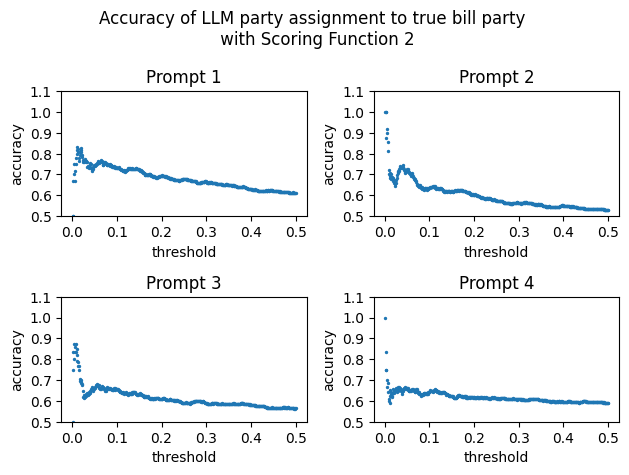

In [174]:
thresholds = np.arange(0.001, 0.501, 0.001)
true_parties = summaries_df_sample[:1000]["true_party"]

fig, ax = plt.subplots(2,2)
ax[0][0].scatter(thresholds, [llm_partisan_scores_accuracy(llm_partisan_scores(D1out, R1out), true_parties, threshold=i, scoring_function=llm_partisan_scores_2) for i in thresholds], s=2)
ax[0][0].set_title("Prompt 1")
ax[0][1].scatter(thresholds, [llm_partisan_scores_accuracy(llm_partisan_scores(D2out, R2out), true_parties, threshold=i, scoring_function=llm_partisan_scores_2) for i in thresholds], s=2)
ax[0][1].set_title("Prompt 2")
ax[1][0].scatter(thresholds, [llm_partisan_scores_accuracy(llm_partisan_scores(D3out, R3out), true_parties, threshold=i, scoring_function=llm_partisan_scores_2) for i in thresholds], s=2)
ax[1][0].set_title("Prompt 3")
ax[1][1].scatter(thresholds, [llm_partisan_scores_accuracy(llm_partisan_scores(D4out, R4out), true_parties, threshold=i, scoring_function=llm_partisan_scores_2) for i in thresholds], s=2)
ax[1][1].set_title("Prompt 4")

for axs in ax.flat:
    axs.set_xlabel("threshold")
    axs.set_ylabel("accuracy")
    axs.set_ylim(0.5, 1)
    axs.set_xticks(np.arange(0, 0.51, 0.1))
    axs.set_yticks(np.arange(0.5, 1.1, 0.1))

fig.suptitle("Accuracy of LLM party assignment to true bill party \n with Scoring Function 2")
fig.tight_layout()
fig.show()

In [156]:
# MEAN OVER ALL BILLS ((ACTIVATIONS | DEM) - (ACTIVATIONS | REP))
def mean_activation_difference(Dstream, Rstream, selected_bill_indices="all", normalize=False):
    if selected_bill_indices == "all":
        selected_bill_indices = jnp.arange(Dstream.named_shape["bill"])
    Dstream_selected = Dstream.untag("bill")[selected_bill_indices].tag("bill")
    Rstream_selected = Rstream.untag("bill")[selected_bill_indices].tag("bill")
    difference = (Dstream_selected.untag("embedding") - Rstream_selected.untag("embedding")).tag("embedding")
    mean_difference = pz.nx.nmap(jnp.mean)(difference.untag("bill"))
    if normalize:
        mean_difference = mean_difference / pz.nx.nmap(jnp.linalg.norm)(mean_difference.untag("embedding"))
    return mean_difference

If this experiment worked, I would expect that the activation differences from the four similar prompt styles to be well-correlated. Again, whether they are well-correleted is up to interpretation. The fact that correlated-ness increases is good, but the fact that it stops increasing around layer 8 instead of closer to 13 or 14 is not good. The active negative correlation between prompts 3 and 4 is very strange - perhaps I have bug. 

In [84]:
corr_matrix = pz.nx.stack([pz.nx.stack([ 
                                        pz.nx.nmap(jnp.corrcoef)(mean_activation_difference(eval("D" + str(i) + "stream"), eval("R" + str(i) + "stream")).untag("embedding"),
                                                                 mean_activation_difference(eval("D" + str(j) + "stream"), eval("R" + str(j) + "stream")).untag("embedding"))[0,1]
                                        for i in range(1,5)], "prompt-2")
                             for j in range(1,5)], "prompt-1")
corr_matrix

<NamedArray float32(| layer:18, prompt-2:4, prompt-1:4) ≈0.34 ±0.43 [≥-0.43, ≤1.0] nonzero:288 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [157]:
# Project arr_of_embeddings into some single direction in the embedding space, collapsing that dimension into a single "score"
def directional_distance(direction, arr_of_embeddings):
    return pz.nx.nmap(jnp.dot)(direction.untag("embedding"), arr_of_embeddings.untag("embedding"))

directional_distance(mean_activation_difference(D1stream, R1stream), D1stream)

<NamedArray float32(| layer:18, bill:1000) ≈-1.4e+02 ±2.4e+02 [≥-1.5e+03, ≤3.2e+01] nonzero:18_000 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

# Activation Patching

In [179]:
@pz.pytree_dataclass
class DebiasRepresentation(pz.nn.Layer):
    """Layer that adds an untrainable bias
    
    Attributes:
    direction: a unit vector of the same dimension as the embedding
    debiasing_factor: how much to move the embedding in the given direction by
    """
    direction: pz.nx.NamedArray
    debiasing_factor: jnp.float32

    def __call__(self, x: pz.nx.NamedArray, /, **unused_side_inputs) -> pz.nx.NamedArray:
        return x - (self.debiasing_factor * self.direction) # might have to make .value

def get_debiased_model(original_model, activation_num, direction, factor):
    return pz.select(original_model).at(
        lambda model: [layer for layer in model.body.sublayers if isinstance(layer, penzai.models.transformer.model_parts.TransformerBlock)][activation_num]
    ).insert_after(DebiasRepresentation(direction, factor))

In [180]:
activation_num = 15
debiased_model = get_debiased_model(model, 15, mean_activation_difference(D1stream, R1stream, normalize=True).untag("layer")[activation_num], 1)

In [185]:
prompt = summaries_df_sample.iloc[[731]]["summary"]
tokenized_prompts, attention_masks = tokenize_and_pad_vectorized(prompt, padding_last=False)    # TODO: attention mask looks wrong
input_batch = pz.nx.wrap(tokenized_prompts).tag("prompt", "seq")
input_token_pos = (pz.nx.arange("seq", input_batch.named_shape["seq"]) *
                   pz.nx.ones({"prompt":input_batch.named_shape["prompt"]}) + 1) * (input_batch != 0) - 1

original_model_outputs = model(input_batch, token_positions=input_token_pos).untag("seq")[-1]
debiased_model_outputs = debiased_model(input_batch, token_positions=input_token_pos).untag("seq")[-1]

2024-08-15 22:34:45.001536: W external/xla/xla/service/gpu/gemm_fusion_autotuner.cc:774] Compiling 32 configs for gemm_fusion_dot on a single thread.
2024-08-15 22:34:52.953448: W external/xla/xla/service/gpu/gemm_fusion_autotuner.cc:774] Compiling 32 configs for gemm_fusion_dot on a single thread.
2024-08-15 22:35:01.056065: W external/xla/xla/service/gpu/gemm_fusion_autotuner.cc:774] Compiling 32 configs for gemm_fusion_dot on a single thread.
2024-08-15 22:35:07.099089: W external/xla/xla/service/gpu/gemm_fusion_autotuner.cc:774] Compiling 32 configs for gemm_fusion_dot on a single thread.
2024-08-15 22:35:15.135476: W external/xla/xla/service/gpu/gemm_fusion_autotuner.cc:774] Compiling 32 configs for gemm_fusion_dot on a single thread.
2024-08-15 22:35:24.003968: W external/xla/xla/service/gpu/gemm_fusion_autotuner.cc:774] Compiling 32 configs for gemm_fusion_dot on a single thread.


In [186]:
prompt

731     <p><b>Climate Solutions Act of 2021</b></p> <...
Name: summary, dtype: object

In [187]:
llm_sentiment_difference(original_model_outputs)

<NamedArray float32(| prompt:1) ≈0.43 ±0.0 [≥0.43, ≤0.43] nonzero:1 (wrapping jax.Array)>

In [188]:
llm_sentiment_difference(debiased_model_outputs)

<NamedArray float32(| prompt:1) ≈0.3 ±0.0 [≥0.3, ≤0.3] nonzero:1 (wrapping jax.Array)>